# Deteksi Phishing dengan CNN + LSTM - Raw URL Approach

## Penelitian Tugas Akhir
**Deteksi Phishing menggunakan Deep Learning pada Raw URL dengan Arsitektur Character-Level CNN-LSTM**

### Deskripsi Proyek
Notebook ini mengimplementasikan deteksi phishing menggunakan **raw URL** (tanpa ekstraksi fitur manual) dengan deep learning. Model akan belajar sendiri pattern dari karakter-karakter URL.

### Perbedaan dengan Pendekatan Sebelumnya:
| Aspek | Pendekatan Lama | Pendekatan Baru (Raw URL) |
|-------|-----------------|---------------------------|
| **Input** | 41 fitur numerik (extracted) | Raw URL string |
| **Feature Engineering** | Manual (41 fitur) | Automatic (by CNN-LSTM) |
| **Preprocessing** | Scaling | Character encoding |
| **Learning** | Pattern dari fitur | Pattern dari karakter |
| **Interpretability** | Feature importance | Attention mechanism |

### Dataset
- **Phishing URLs**: 49,052 dari PhishTank (real phishing URLs yang disebarkan online)
- **Legitimate URLs**: 49,052 dari Alexa Top-1M (top legitimate domains)
- **Total**: 98,104 URLs (balanced 50-50)

### Arsitektur Model
```
Raw URL String
    ↓
Character Encoding (vocab_size ~100)
    ↓
Embedding Layer (50-dim)
    ↓
CNN Layers (extract local patterns)
    ↓
LSTM Layers (capture sequential dependencies)
    ↓
Dense Layers (classification)
    ↓
Output (Legitimate vs Phishing)
```

### Hardware
- **GPU**: NVIDIA RTX 2050 (akan digunakan untuk training)
- **Mixed Precision**: Enabled untuk optimasi memori

## 1. Import Libraries dan Setup Environment

In [1]:
# Import library untuk data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, 
                             accuracy_score, precision_score, recall_score, f1_score)

# Import TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, LSTM, Dense, 
                                     Dropout, Flatten, BatchNormalization, Bidirectional,
                                     Input, GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import mixed_precision

# Import library tambahan
import warnings
import os
import json
import pickle
from datetime import datetime
from collections import Counter
import string

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

d:\app\envs\steganalysis\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


TensorFlow Version: 2.10.0
Keras Version: 2.10.0


In [2]:
# GPU Configuration dan Mixed Precision
print("="*70)
print(" "*20 + "GPU DETECTION & SETUP")
print("="*70)

# Check GPU devices
gpus = tf.config.list_physical_devices('GPU')
print(f"\n{'✅' if gpus else '⚠️'}  GPU Devices Found: {len(gpus)}")

if gpus:
    print("\n🎉 GPU TERDETEKSI!")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu.name}")
        # Set memory growth untuk avoid OOM
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"   ✓ Memory growth enabled for GPU {i}")
        except Exception as e:
            print(f"   ⚠️  Memory growth error: {e}")
    
    # Enable Mixed Precision untuk RTX 2050
    print("\n🚀 ENABLING MIXED PRECISION")
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"   ✓ Mixed precision enabled: {policy.name}")
    print("   ✓ Compute dtype:", policy.compute_dtype)
    print("   ✓ Variable dtype:", policy.variable_dtype)
    print("\n✅ Model akan training menggunakan GPU dengan Mixed Precision (SANGAT CEPAT)")
    
else:
    print("\n⚠️  GPU TIDAK TERDETEKSI")
    print("\n📌 INFORMASI:")
    print("   • Training akan menggunakan CPU")
    print("   • Proses akan lebih lambat")
    print("\n🔧 CARA ENABLE GPU (Jika punya NVIDIA GPU):")
    print("   1. Install CUDA Toolkit")
    print("   2. Install cuDNN")
    print("   3. pip install tensorflow[and-cuda]")

print("\n" + "="*70)

                    GPU DETECTION & SETUP

⚠️  GPU Devices Found: 0

⚠️  GPU TIDAK TERDETEKSI

📌 INFORMASI:
   • Training akan menggunakan CPU
   • Proses akan lebih lambat

🔧 CARA ENABLE GPU (Jika punya NVIDIA GPU):
   1. Install CUDA Toolkit
   2. Install cuDNN
   3. pip install tensorflow[and-cuda]



## 2. Load dan Combine Dataset

### Dataset Sources:
1. **PhishTank** (`dataset/phishtank.csv`) - 49,052 phishing URLs
2. **Alexa Top-1M** (`dataset/top-1m.csv`) - Top legitimate domains

### Strategy:
- Load phishing URLs dari PhishTank
- Load 49,052 legitimate domains dari Top-1M (untuk balance)
- Convert domain → full URL format
- Combine dan shuffle

In [3]:
# Load PhishTank dataset (Phishing URLs)
print("="*70)
print("LOADING PHISHING URLs")
print("="*70)

phishtank_df = pd.read_csv('dataset/phishtank.csv')
print(f"✓ Loaded {len(phishtank_df):,} phishing URLs from PhishTank")
print(f"Columns: {phishtank_df.columns.tolist()}")

# Extract URL dan add label
phishing_urls = phishtank_df[['url']].copy()
phishing_urls['label'] = 1  # Phishing = 1
phishing_urls['source'] = 'PhishTank'

print(f"\nSample Phishing URLs:")
for i, url in enumerate(phishing_urls['url'].head(5)):
    print(f"  {i+1}. {url}")

LOADING PHISHING URLs
✓ Loaded 49,052 phishing URLs from PhishTank
Columns: ['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified', 'verification_time', 'online', 'target']

Sample Phishing URLs:
  1. https://bcrecer.vercel.app/
  2. https://rmrtrqar.com/
  3. https://reserved-customers-742084.framer.app/
  4. http://allegrolokalnie.pl-oferta16818-macbook-air-m1-16-512-gb.sbs
  5. https://ficohsanbonline.help/#/


In [4]:
# Load Alexa Top-1M dataset (Legitimate domains)
print("\n" + "="*70)
print("LOADING LEGITIMATE DOMAINS")
print("="*70)

# Load top-1m.csv (no header)
top1m_df = pd.read_csv('dataset/top-1m.csv', header=None, names=['rank', 'domain'])
print(f"✓ Loaded {len(top1m_df):,} domains from Alexa Top-1M")

# Ambil 49,052 domains pertama (sama dengan jumlah phishing)
num_legitimate = len(phishing_urls)
legitimate_df = top1m_df.head(num_legitimate).copy()

# Convert domain → full URL (add https:// prefix and / suffix)
legitimate_df['url'] = 'https://' + legitimate_df['domain'] + '/'
legitimate_df['label'] = 0  # Legitimate = 0
legitimate_df['source'] = 'Alexa-Top1M'

# Select only url, label, source columns
legitimate_urls = legitimate_df[['url', 'label', 'source']].copy()

print(f"✓ Selected top {num_legitimate:,} legitimate domains")
print(f"\nSample Legitimate URLs:")
for i, url in enumerate(legitimate_urls['url'].head(5)):
    print(f"  {i+1}. {url}")


LOADING LEGITIMATE DOMAINS
✓ Loaded 1,000,000 domains from Alexa Top-1M
✓ Selected top 49,052 legitimate domains

Sample Legitimate URLs:
  1. https://google.com/
  2. https://microsoft.com/
  3. https://www.google.com/
  4. https://data.microsoft.com/
  5. https://events.data.microsoft.com/



COMBINING DATASETS
✓ Combined dataset created
Total URLs: 98,104

Class Distribution:
  Legitimate (0): 49,052 (50.00%)
  Phishing (1): 49,052 (50.00%)


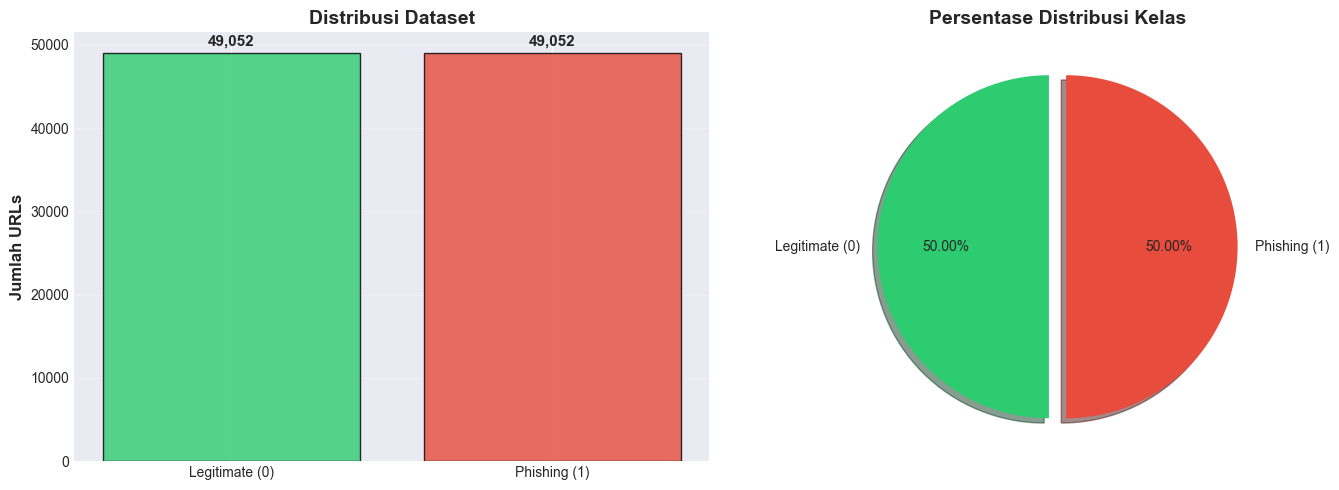


✓ Dataset ready for preprocessing!


In [5]:
# Combine dan shuffle dataset
print("\n" + "="*70)
print("COMBINING DATASETS")
print("="*70)

# Combine phishing dan legitimate
df = pd.concat([phishing_urls, legitimate_urls], ignore_index=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✓ Combined dataset created")
print(f"Total URLs: {len(df):,}")
print(f"\nClass Distribution:")
class_counts = df['label'].value_counts().sort_index()
for label, count in class_counts.items():
    label_name = "Legitimate" if label == 0 else "Phishing"
    print(f"  {label_name} ({label}): {count:,} ({count/len(df)*100:.2f}%)")

# Visualisasi distribusi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
labels_list = ['Legitimate (0)', 'Phishing (1)']
values = [class_counts[0], class_counts[1]]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(labels_list, values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Jumlah URLs', fontsize=12, fontweight='bold')
axes[0].set_title('Distribusi Dataset', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    axes[0].text(i, v + (max(values) * 0.01), f'{v:,}', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(values, labels=labels_list, autopct='%1.2f%%', colors=colors,
           explode=(0.05, 0.05), shadow=True, startangle=90)
axes[1].set_title('Persentase Distribusi Kelas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/raw_url_dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Dataset ready for preprocessing!")
print("="*70)

## 3. URL Analysis dan Character-Level Encoding

### Preprocessing Strategy:
1. **Analisis panjang URL** untuk menentukan `max_length`
2. **Build character vocabulary** dari semua URL
3. **Character-to-Index mapping**
4. **Tokenization**: URL → sequence of character indices
5. **Padding/Truncation**: Uniform length untuk neural network input

URL LENGTH ANALYSIS

Statistik Panjang URL:
  Min length:    12 characters
  Max length:    25523 characters
  Mean length:   49.55 characters
  Median length: 34 characters
  Std deviation: 126.85

Percentiles:
  50th percentile: 34 characters
  75th percentile: 48 characters
  90th percentile: 84 characters
  95th percentile: 175 characters
  99th percentile: 192 characters


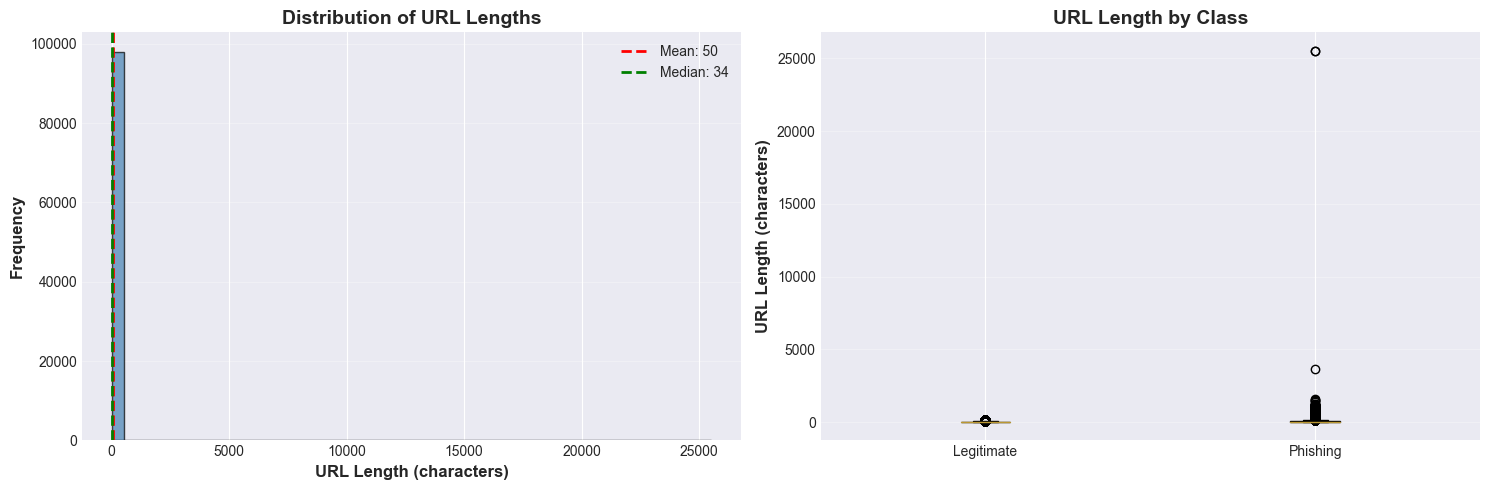


✓ Selected MAX_LENGTH: 175 characters (95th percentile)
  → 95855 URLs (97.71%) will be fully captured
  → 2249 URLs (2.29%) will be truncated


In [6]:
# Analisis panjang URL
print("="*70)
print("URL LENGTH ANALYSIS")
print("="*70)

url_lengths = df['url'].str.len()

print(f"\nStatistik Panjang URL:")
print(f"  Min length:    {url_lengths.min()} characters")
print(f"  Max length:    {url_lengths.max()} characters")
print(f"  Mean length:   {url_lengths.mean():.2f} characters")
print(f"  Median length: {url_lengths.median():.0f} characters")
print(f"  Std deviation: {url_lengths.std():.2f}")

# Percentiles
percentiles = [50, 75, 90, 95, 99]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(url_lengths, p)
    print(f"  {p}th percentile: {value:.0f} characters")

# Visualisasi distribusi panjang URL
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(url_lengths, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(url_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {url_lengths.mean():.0f}')
axes[0].axvline(url_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {url_lengths.median():.0f}')
axes[0].set_xlabel('URL Length (characters)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of URL Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot per class
url_lengths_by_class = [df[df['label']==0]['url'].str.len(), 
                        df[df['label']==1]['url'].str.len()]
axes[1].boxplot(url_lengths_by_class, labels=['Legitimate', 'Phishing'], patch_artist=True)
axes[1].set_ylabel('URL Length (characters)', fontsize=12, fontweight='bold')
axes[1].set_title('URL Length by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/raw_url_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Tentukan max_length (95th percentile untuk balance antara info dan efficiency)
max_length = int(np.percentile(url_lengths, 95))
print(f"\n✓ Selected MAX_LENGTH: {max_length} characters (95th percentile)")
print(f"  → {(url_lengths <= max_length).sum()} URLs ({(url_lengths <= max_length).sum()/len(df)*100:.2f}%) will be fully captured")
print(f"  → {(url_lengths > max_length).sum()} URLs ({(url_lengths > max_length).sum()/len(df)*100:.2f}%) will be truncated")

In [7]:
# Build Character Vocabulary
print("\n" + "="*70)
print("BUILDING CHARACTER VOCABULARY")
print("="*70)

# Collect all unique characters from URLs
all_chars = set()
for url in df['url']:
    all_chars.update(url)

# Sort untuk consistency
all_chars = sorted(list(all_chars))

print(f"\n✓ Found {len(all_chars)} unique characters in URLs")
print(f"\nCharacter samples:")
print(f"  First 20: {''.join(all_chars[:20])}")
print(f"  Last 20:  {''.join(all_chars[-20:])}")

# Analisis character types
letters = [c for c in all_chars if c.isalpha()]
digits = [c for c in all_chars if c.isdigit()]
special = [c for c in all_chars if not c.isalnum()]

print(f"\nCharacter breakdown:")
print(f"  Letters: {len(letters)} ({''.join(letters[:10])}...)")
print(f"  Digits:  {len(digits)} ({''.join(digits)})")
print(f"  Special: {len(special)} ({''.join(special[:20])}...)")

# Create character-to-index mapping
# Reserve 0 for padding, 1 for unknown
char_to_idx = {char: idx + 2 for idx, char in enumerate(all_chars)}
char_to_idx['<PAD>'] = 0  # Padding
char_to_idx['<UNK>'] = 1  # Unknown character

idx_to_char = {idx: char for char, idx in char_to_idx.items()}

vocab_size = len(char_to_idx)

print(f"\n✓ Vocabulary created")
print(f"  Vocab size: {vocab_size} (including <PAD> and <UNK>)")
print(f"  Index 0: <PAD> (padding)")
print(f"  Index 1: <UNK> (unknown)")
print(f"  Index 2-{vocab_size-1}: actual characters")

# Display beberapa mapping
print(f"\nSample mappings:")
sample_chars = ['h', 't', 'p', 's', ':', '/', '.', 'c', 'o', 'm']
for char in sample_chars:
    if char in char_to_idx:
        print(f"  '{char}' → {char_to_idx[char]}")


BUILDING CHARACTER VOCABULARY

✓ Found 95 unique characters in URLs

Character samples:
  First 20:  !#$%&()*+,-./012345
  Last 20:  pqrstuvwxyz{|}~®Â’∕

Character breakdown:
  Letters: 53 (ABCDEFGHIJ...)
  Digits:  10 (0123456789)
  Special: 32 ( !#$%&()*+,-./:;=?@[...)

✓ Vocabulary created
  Vocab size: 97 (including <PAD> and <UNK>)
  Index 0: <PAD> (padding)
  Index 1: <UNK> (unknown)
  Index 2-96: actual characters

Sample mappings:
  'h' → 69
  't' → 81
  'p' → 77
  's' → 80
  ':' → 26
  '/' → 15
  '.' → 14
  'c' → 64
  'o' → 76
  'm' → 74


In [8]:
# URL Tokenization Function
def url_to_sequence(url, char_to_idx, max_length):
    """
    Convert URL string ke sequence of character indices
    
    Parameters:
    -----------
    url : str
        URL string
    char_to_idx : dict
        Character to index mapping
    max_length : int
        Maximum sequence length
    
    Returns:
    --------
    sequence : list
        List of character indices
    """
    sequence = []
    for char in url[:max_length]:  # Truncate jika terlalu panjang
        if char in char_to_idx:
            sequence.append(char_to_idx[char])
        else:
            sequence.append(char_to_idx['<UNK>'])  # Unknown character
    
    # Padding jika terlalu pendek
    while len(sequence) < max_length:
        sequence.append(char_to_idx['<PAD>'])
    
    return sequence

# Test tokenization
print("\n" + "="*70)
print("TESTING TOKENIZATION")
print("="*70)

test_urls = [
    "https://google.com/",
    "http://phishing-site-example.com/login.php"
]

for url in test_urls:
    sequence = url_to_sequence(url, char_to_idx, max_length)
    print(f"\nURL: {url}")
    print(f"Length: {len(url)} characters")
    print(f"Sequence length: {len(sequence)}")
    print(f"First 20 indices: {sequence[:20]}")
    print(f"Last 10 indices: {sequence[-10:]}")
    
    # Decode back untuk verify
    decoded = ''.join([idx_to_char.get(idx, '?') for idx in sequence if idx != 0])
    print(f"Decoded (no padding): {decoded[:50]}...")

print("\n✓ Tokenization function ready!")


TESTING TOKENIZATION

URL: https://google.com/
Length: 19 characters
Sequence length: 175
First 20 indices: [69, 81, 81, 77, 80, 26, 15, 15, 68, 76, 76, 68, 73, 66, 14, 64, 76, 74, 15, 0]
Last 10 indices: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded (no padding): https://google.com/...

URL: http://phishing-site-example.com/login.php
Length: 42 characters
Sequence length: 175
First 20 indices: [69, 81, 81, 77, 26, 15, 15, 77, 69, 70, 80, 69, 70, 75, 68, 13, 80, 70, 81, 66]
Last 10 indices: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded (no padding): http://phishing-site-example.com/login.php...

✓ Tokenization function ready!


In [9]:
# Tokenize All URLs
print("\n" + "="*70)
print("TOKENIZING ALL URLs")
print("="*70)

print(f"Processing {len(df):,} URLs...")

# Convert semua URL ke sequences
sequences = []
for idx, url in enumerate(df['url']):
    if (idx + 1) % 10000 == 0:
        print(f"  Progress: {idx + 1:,}/{len(df):,} ({(idx + 1)/len(df)*100:.1f}%)")
    
    seq = url_to_sequence(url, char_to_idx, max_length)
    sequences.append(seq)

# Convert ke numpy array
X = np.array(sequences)
y = df['label'].values

print(f"\n✓ Tokenization completed!")
print(f"\nData shape:")
print(f"  X shape: {X.shape} (samples, max_length)")
print(f"  y shape: {y.shape}")
print(f"\nData info:")
print(f"  Total URLs: {len(X):,}")
print(f"  Sequence length: {X.shape[1]} characters")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Legitimate (0): {(y == 0).sum():,}")
print(f"  Phishing (1): {(y == 1).sum():,}")


TOKENIZING ALL URLs
Processing 98,104 URLs...
  Progress: 10,000/98,104 (10.2%)
  Progress: 20,000/98,104 (20.4%)
  Progress: 30,000/98,104 (30.6%)
  Progress: 40,000/98,104 (40.8%)
  Progress: 50,000/98,104 (51.0%)
  Progress: 60,000/98,104 (61.2%)
  Progress: 70,000/98,104 (71.4%)
  Progress: 80,000/98,104 (81.5%)
  Progress: 90,000/98,104 (91.7%)

✓ Tokenization completed!

Data shape:
  X shape: (98104, 175) (samples, max_length)
  y shape: (98104,)

Data info:
  Total URLs: 98,104
  Sequence length: 175 characters
  Vocabulary size: 97
  Legitimate (0): 49,052
  Phishing (1): 49,052


## 4. Data Splitting

Split dataset menjadi:
- **Training set**: 65% (untuk training model)
- **Validation set**: 15% (untuk tuning hyperparameter)
- **Test set**: 20% (untuk evaluasi final)

DATA SPLITTING

Dataset split:
  Training:   63,767 samples (65.0%)
  Validation: 14,716 samples (15.0%)
  Test:       19,621 samples (20.0%)
  Total:      98,104 samples

Class distribution:
  Training   : Legitimate=31,883 (50.0%), Phishing=31,884 (50.0%)
  Validation : Legitimate=7,358 (50.0%), Phishing=7,358 (50.0%)
  Test       : Legitimate=9,811 (50.0%), Phishing=9,810 (50.0%)


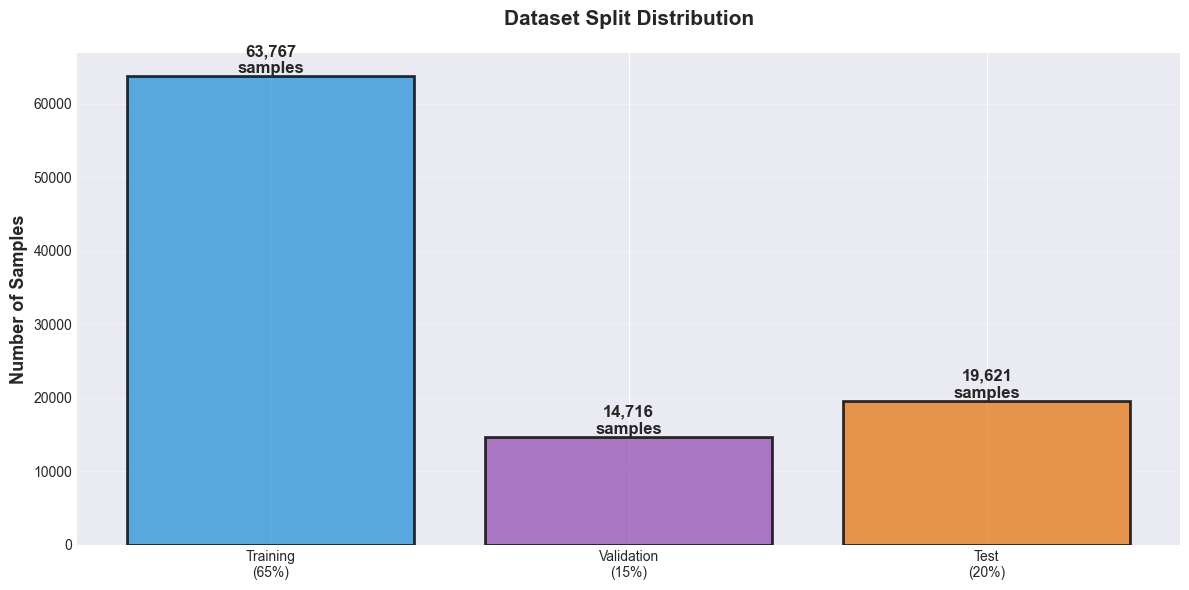


✓ Data splitting completed!


In [10]:
# Split data: Train (65%), Validation (15%), Test (20%)
print("="*70)
print("DATA SPLITTING")
print("="*70)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: dari 80% → 65% train, 15% val
# 15/80 = 0.1875
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, random_state=42, stratify=y_temp
)

print(f"\nDataset split:")
print(f"  Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Total:      {len(X):,} samples")

# Verify class distribution
print(f"\nClass distribution:")
for split_name, y_split in [('Training', y_train), ('Validation', y_val), ('Test', y_test)]:
    legitimate = (y_split == 0).sum()
    phishing = (y_split == 1).sum()
    print(f"  {split_name:11s}: Legitimate={legitimate:,} ({legitimate/len(y_split)*100:.1f}%), "
          f"Phishing={phishing:,} ({phishing/len(y_split)*100:.1f}%)")

# Visualisasi split
fig, ax = plt.subplots(figsize=(12, 6))
splits = ['Training\n(65%)', 'Validation\n(15%)', 'Test\n(20%)']
sizes = [len(X_train), len(X_val), len(X_test)]
colors = ['#3498db', '#9b59b6', '#e67e22']

bars = ax.bar(splits, sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
ax.set_title('Dataset Split Distribution', fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}\nsamples',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/raw_url_data_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Data splitting completed!")

## 5. Build CNN-LSTM Model untuk Raw URL

### Model Architecture:
```
Input (sequence of character indices)
    ↓
Embedding Layer (vocab_size → 128-dim)
    ↓
Conv1D Layers (extract local character patterns)
    • Conv1D-1: 128 filters, kernel=3
    • Conv1D-2: 256 filters, kernel=3
    • Conv1D-3: 512 filters, kernel=3
    ↓
Bidirectional LSTM Layers (capture sequential dependencies)
    • BiLSTM-1: 128 units
    • BiLSTM-2: 64 units
    ↓
Dense Layers (classification)
    • Dense-1: 128 units + Dropout
    • Dense-2: 64 units + Dropout
    ↓
Output Layer (Sigmoid - binary classification)
```

### Key Differences from Feature-Based Model:
- **Input**: Character sequences (not 41 numeric features)
- **Embedding**: Learn character representations
- **CNN**: Extract n-gram patterns (like "http", "login", "secure", dll)
- **LSTM**: Capture long-range dependencies in URL structure

In [11]:
# Build CNN-LSTM Model
def build_cnn_lstm_raw_url_model(vocab_size, max_length, embedding_dim=128):
    """
    Build CNN-LSTM model untuk raw URL classification
    
    Parameters:
    -----------
    vocab_size : int
        Size of character vocabulary
    max_length : int
        Maximum URL length (sequence length)
    embedding_dim : int
        Dimension of character embeddings
    
    Returns:
    --------
    model : keras.Model
        Compiled model
    """
    model = Sequential(name='CNN_LSTM_Raw_URL')
    
    # ===== EMBEDDING LAYER =====
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        name='char_embedding'
    ))
    
    # ===== CNN LAYERS (Extract local character patterns) =====
    # Layer 1: Conv1D + BatchNorm + MaxPooling
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='conv1d_1'))
    model.add(BatchNormalization(name='batch_norm_1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(Dropout(0.25, name='dropout_1'))
    
    # Layer 2: Conv1D + BatchNorm + MaxPooling
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', name='conv1d_2'))
    model.add(BatchNormalization(name='batch_norm_2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(Dropout(0.25, name='dropout_2'))
    
    # Layer 3: Conv1D + BatchNorm
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', name='conv1d_3'))
    model.add(BatchNormalization(name='batch_norm_3'))
    model.add(Dropout(0.3, name='dropout_3'))
    
    # ===== BIDIRECTIONAL LSTM LAYERS (Capture sequential dependencies) =====
    # Layer 1: BiLSTM with return sequences
    model.add(Bidirectional(LSTM(128, return_sequences=True, name='lstm_1'), name='bilstm_1'))
    model.add(Dropout(0.3, name='dropout_4'))
    
    # Layer 2: BiLSTM without return sequences
    model.add(Bidirectional(LSTM(64, return_sequences=False, name='lstm_2'), name='bilstm_2'))
    model.add(Dropout(0.4, name='dropout_5'))
    
    # ===== DENSE LAYERS (Classification) =====
    model.add(Dense(128, activation='relu', name='dense_1'))
    model.add(Dropout(0.5, name='dropout_6'))
    
    model.add(Dense(64, activation='relu', name='dense_2'))
    model.add(Dropout(0.5, name='dropout_7'))
    
    # ===== OUTPUT LAYER =====
    # Use float32 untuk output layer (mixed precision compatibility)
    model.add(Dense(1, activation='sigmoid', dtype='float32', name='output'))
    
    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Build model
print("="*70)
print("BUILDING CNN-LSTM MODEL FOR RAW URL")
print("="*70)

model = build_cnn_lstm_raw_url_model(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

print("\n✓ Model created successfully!")
print("\nModel Summary:")
model.summary()

BUILDING CNN-LSTM MODEL FOR RAW URL

✓ Model created successfully!

Model Summary:
Model: "CNN_LSTM_Raw_URL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_embedding (Embedding)  (None, 175, 128)          12416     
                                                                 
 conv1d_1 (Conv1D)           (None, 175, 128)          49280     
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 175, 128)         512       
 ation)                                                          
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 87, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 87, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (Non

## Tahap 7: Konfigurasi Training

Setup callbacks untuk:
- **Early Stopping**: Stop training jika tidak ada improvement
- **Model Checkpoint**: Save best model
- **ReduceLROnPlateau**: Kurangi learning rate jika stuck
- **TensorBoard**: Logging untuk monitoring

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

# Create directories for saving
os.makedirs('models', exist_ok=True)
os.makedirs('logs/fit_raw_url', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Early Stopping: Stop jika val_loss tidak improve selama 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save best model
checkpoint = ModelCheckpoint(
    'models/best_raw_url_cnn_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce Learning Rate: Kurangi LR jika val_loss plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# TensorBoard: Logging untuk monitoring
log_dir = "logs/fit_raw_url/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stop, checkpoint, reduce_lr, tensorboard_callback]

print("✓ Callbacks configured:")
print(f"  - Early Stopping (patience=10)")
print(f"  - Model Checkpoint -> models/best_raw_url_cnn_lstm_model.h5")
print(f"  - Reduce LR on Plateau (factor=0.5, patience=5)")
print(f"  - TensorBoard -> {log_dir}")
print(f"\nReady for training!")

✓ Callbacks configured:
  - Early Stopping (patience=10)
  - Model Checkpoint -> models/best_raw_url_cnn_lstm_model.h5
  - Reduce LR on Plateau (factor=0.5, patience=5)
  - TensorBoard -> logs/fit_raw_url/20251224-111230

Ready for training!


## Tahap 8: Training Model

Mulai training dengan konfigurasi:
- **Epochs**: 100 (dengan early stopping)
- **Batch Size**: 128
- **Validation**: Menggunakan validation set (15% data)

**Note**: Training dengan CPU akan memakan waktu ~1-2 jam untuk 98K URLs. Pantau progress melalui output atau TensorBoard.

In [13]:
import time

print("=" * 70)
print("STARTING TRAINING - RAW URL CNN-LSTM MODEL")
print("=" * 70)
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Total epochs: 100 (with early stopping)")
print(f"Batch size: 128")
print("=" * 70)

start_time = time.time()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETED!")
print("=" * 70)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print("=" * 70)

STARTING TRAINING - RAW URL CNN-LSTM MODEL
Training samples: 63,767
Validation samples: 14,716
Test samples: 19,621
Total epochs: 100 (with early stopping)
Batch size: 128
Epoch 1/100
499/499 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9434 - precision: 0.9584 - recall: 0.9271 - auc: 0.9852
Epoch 1: val_accuracy improved from -inf to 0.91900, saving model to models\best_raw_url_cnn_lstm_model.h5
499/499 [==============================] - 393s 771ms/step - loss: 0.1435 - accuracy: 0.9434 - precision: 0.9584 - recall: 0.9271 - auc: 0.9852 - val_loss: 0.2104 - val_accuracy: 0.9190 - val_precision: 1.0000 - val_recall: 0.8380 - val_auc: 0.9922 - lr: 0.0010
Epoch 2/100
499/499 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9819 - precision: 0.9908 - recall: 0.9729 - auc: 0.9959
Epoch 2: val_accuracy improved from 0.91900 to 0.98349, saving model to models\best_raw_url_cnn_lstm_model.h5
499/499 [==============================] - 311s 624ms

## Tahap 9: Visualisasi Training History

Plot kurva learning untuk melihat:
- Training vs Validation Accuracy
- Training vs Validation Loss
- Identifikasi overfitting atau underfitting

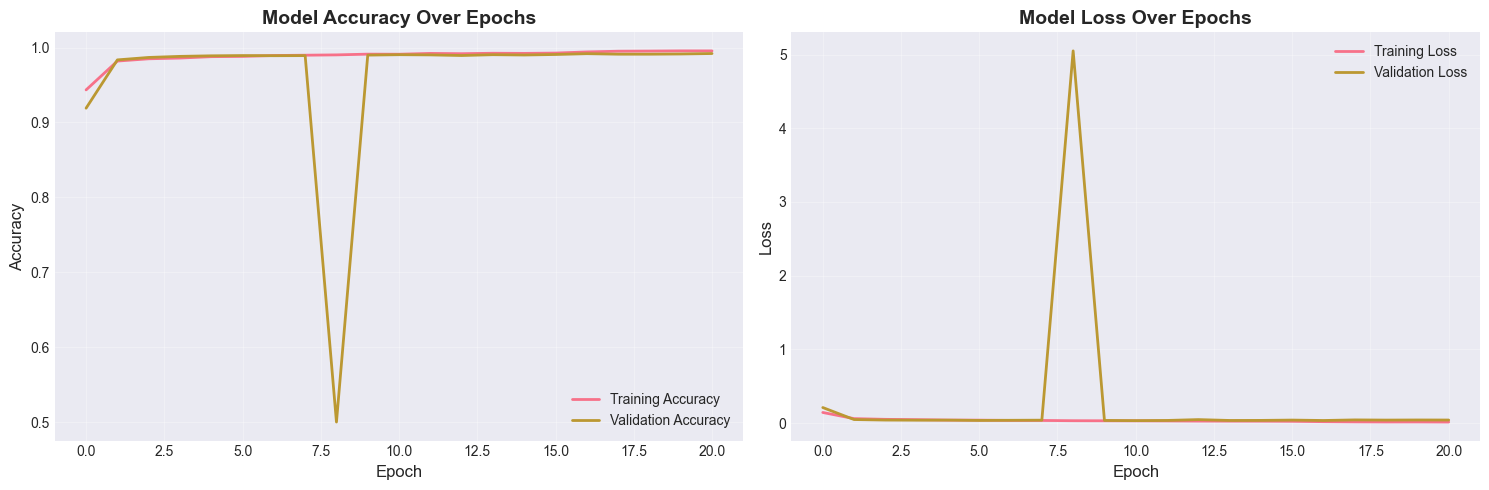

✓ Training history plot saved to: results/raw_url_training_history.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/raw_url_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to: results/raw_url_training_history.png")

## Tahap 10: Evaluasi Model pada Test Set

Evaluasi performa final model menggunakan test set yang belum pernah dilihat model.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Evaluate on test set
print("Evaluating model on test set...")
test_results = model.evaluate(X_test, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]

print("\n" + "=" * 70)
print("TEST SET EVALUATION RESULTS")
print("=" * 70)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
if len(test_results) > 2:
    print(f"Test Precision: {test_results[2]:.4f}")
    print(f"Test Recall:    {test_results[3]:.4f}")
    print(f"Test AUC:       {test_results[4]:.4f}")
print("=" * 70)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("-" * 70)
print(classification_report(y_test, y_pred, 
                          target_names=['Legitimate (0)', 'Phishing (1)'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nCONFUSION MATRIX:")
print("-" * 70)
print(f"                 Predicted")
print(f"              Legit  Phishing")
print(f"Actual Legit   {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"     Phishing  {cm[1,0]:5d}  {cm[1,1]:5d}")
print("-" * 70)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print("\nADDITIONAL METRICS:")
print("-" * 70)
print(f"True Negatives (TN):  {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP):  {tp:,}")
print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"F1-Score:             {f1:.4f}")
print(f"ROC-AUC Score:        {roc_auc_score(y_test, y_pred_proba):.4f}")
print("=" * 70)

Evaluating model on test set...

TEST SET EVALUATION RESULTS
Test Loss:      0.0318
Test Accuracy:  0.9908 (99.08%)
Test Precision: 0.9965
Test Recall:    0.9851
Test AUC:       0.9982

CLASSIFICATION REPORT:
----------------------------------------------------------------------
                precision    recall  f1-score   support

Legitimate (0)     0.9853    0.9965    0.9909      9811
  Phishing (1)     0.9965    0.9851    0.9908      9810

      accuracy                         0.9908     19621
     macro avg     0.9909    0.9908    0.9908     19621
  weighted avg     0.9909    0.9908    0.9908     19621


CONFUSION MATRIX:
----------------------------------------------------------------------
                 Predicted
              Legit  Phishing
Actual Legit    9777     34
     Phishing    146   9664
----------------------------------------------------------------------

ADDITIONAL METRICS:
----------------------------------------------------------------------
True Negatives 

## Tahap 11: Visualisasi Hasil Evaluasi

Visualisasi Confusion Matrix dan ROC Curve untuk analisis performa model.

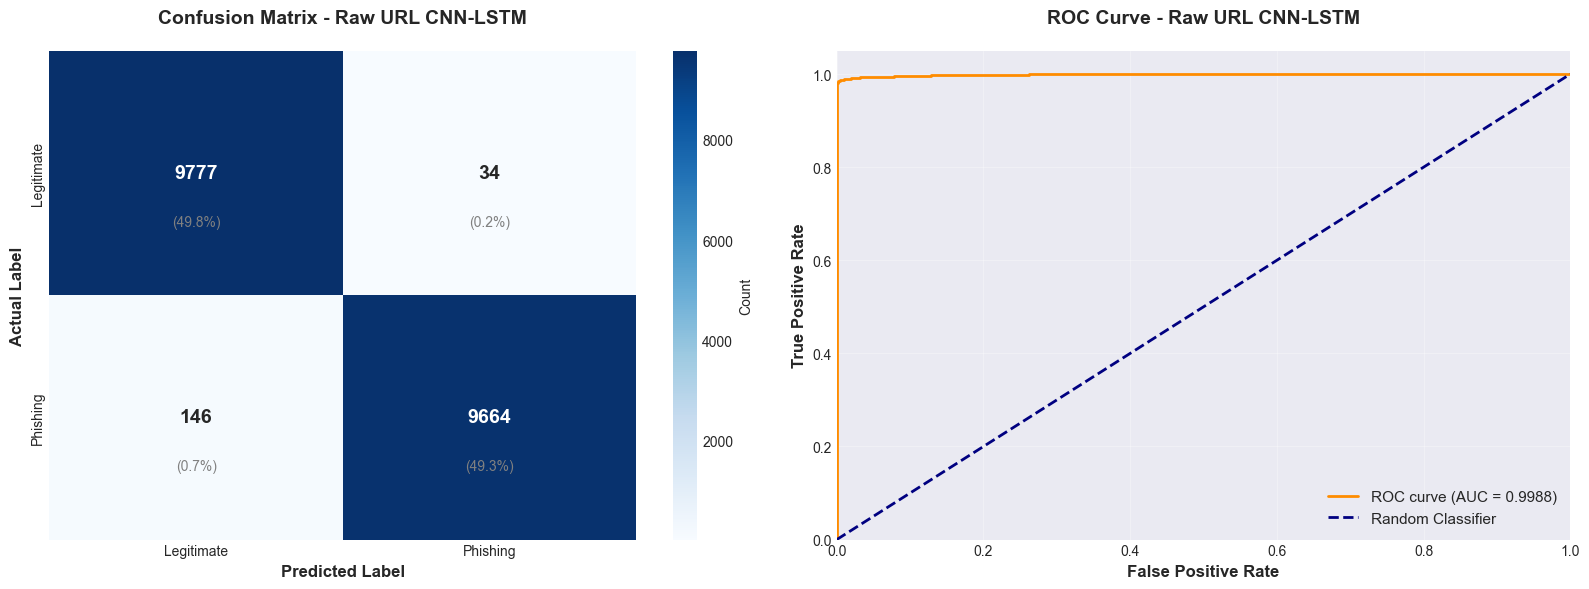

✓ Evaluation plots saved to: results/raw_url_evaluation_plots.png


In [16]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'],
            ax=axes[0], cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix - Raw URL CNN-LSTM', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentages
total = np.sum(cm)
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        axes[0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

# Plot 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curve - Raw URL CNN-LSTM', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/raw_url_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Evaluation plots saved to: results/raw_url_evaluation_plots.png")

## Tahap 12: Save Model dan Results

Simpan model, vocabulary mapping, dan hasil evaluasi untuk deployment atau analisis lebih lanjut.

In [17]:
import json
import pickle

# 1. Save final model (best weights already saved by ModelCheckpoint)
model.save('models/raw_url_cnn_lstm_final.h5')
print("✓ Final model saved to: models/raw_url_cnn_lstm_final.h5")
print("✓ Best model saved to: models/best_raw_url_cnn_lstm_model.h5")

# 2. Save vocabulary mappings
vocab_data = {
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'vocab_size': vocab_size,
    'max_length': max_length
}

with open('models/raw_url_vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
print("✓ Vocabulary saved to: models/raw_url_vocabulary.pkl")

# 3. Save training history
history_data = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'epochs': len(history.history['accuracy']),
    'training_time_minutes': float(training_time/60)
}

with open('results/raw_url_training_history.json', 'w') as f:
    json.dump(history_data, f, indent=4)
print("✓ Training history saved to: results/raw_url_training_history.json")

# 4. Save evaluation results
eval_results = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'confusion_matrix': cm.tolist(),
    'metrics': {
        'sensitivity_recall': float(sensitivity),
        'specificity': float(specificity),
        'precision': float(precision),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc_score(y_test, y_pred_proba))
    },
    'classification_report': classification_report(y_test, y_pred, 
                                                   target_names=['Legitimate', 'Phishing'],
                                                   output_dict=True)
}

with open('results/raw_url_evaluation_results.json', 'w') as f:
    json.dump(eval_results, f, indent=4)
print("✓ Evaluation results saved to: results/raw_url_evaluation_results.json")

# 5. Save model summary
with open('models/raw_url_model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✓ Model summary saved to: models/raw_url_model_summary.txt")

print("\n" + "=" * 70)
print("ALL FILES SAVED SUCCESSFULLY!")
print("=" * 70)
print("\nSaved files:")
print("  Models:")
print("    - models/best_raw_url_cnn_lstm_model.h5 (best checkpoint)")
print("    - models/raw_url_cnn_lstm_final.h5 (final model)")
print("    - models/raw_url_vocabulary.pkl (char mappings)")
print("    - models/raw_url_model_summary.txt")
print("  Results:")
print("    - results/raw_url_training_history.json")
print("    - results/raw_url_evaluation_results.json")
print("    - results/raw_url_training_history.png")
print("    - results/raw_url_evaluation_plots.png")
print("=" * 70)

✓ Final model saved to: models/raw_url_cnn_lstm_final.h5
✓ Best model saved to: models/best_raw_url_cnn_lstm_model.h5
✓ Vocabulary saved to: models/raw_url_vocabulary.pkl
✓ Training history saved to: results/raw_url_training_history.json
✓ Evaluation results saved to: results/raw_url_evaluation_results.json
✓ Model summary saved to: models/raw_url_model_summary.txt

ALL FILES SAVED SUCCESSFULLY!

Saved files:
  Models:
    - models/best_raw_url_cnn_lstm_model.h5 (best checkpoint)
    - models/raw_url_cnn_lstm_final.h5 (final model)
    - models/raw_url_vocabulary.pkl (char mappings)
    - models/raw_url_model_summary.txt
  Results:
    - results/raw_url_training_history.json
    - results/raw_url_evaluation_results.json
    - results/raw_url_training_history.png
    - results/raw_url_evaluation_plots.png


## Tahap 13: Testing dengan URL Baru (Opsional)

Anda dapat menguji model dengan URL baru:

```python
def predict_url(url):
    # Encode URL
    encoded = [char_to_idx.get(char, char_to_idx.get('<UNK>', 0)) for char in url.lower()]
    # Pad sequence
    padded = pad_sequences([encoded], maxlen=max_length, padding='post', truncating='post')
    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]
    return prediction, 'Phishing' if prediction >= 0.5 else 'Legitimate'
```

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_url(url):
    """Prediksi URL apakah phishing atau legitimate"""
    # Encode URL to character indices
    encoded = [char_to_idx.get(char, char_to_idx.get('<UNK>', 0)) for char in url.lower()]
    
    # Pad sequence
    padded = pad_sequences([encoded], maxlen=max_length, padding='post', truncating='post')
    
    # Predict
    prediction_proba = model.predict(padded, verbose=0)[0][0]
    prediction_label = 'Phishing' if prediction_proba >= 0.5 else 'Legitimate'
    
    return prediction_proba, prediction_label

# Test dengan beberapa contoh URL
test_urls = [
    # URL Phishing (dari dataset asli)
    "https://sites.google.com/view/etyajdnxnskoeprlwyaxbdhfkrituy/btconnect",
    
    # URL Legitimate (popular websites)
    "https://google.com/",
    "https://youtube.com/",
    "https://facebook.com/",
    "https://amazon.com/",
    "https://microsoft.com/",
    "https://wikipedia.org/",
    "https://github.com/",
    "https://stackoverflow.com/",
    "https://ctldl.windowsupdate.com/",
]

print("Testing Model with Sample URLs:")
print("=" * 90)
print(f"{'No':<4} {'URL':<50} {'Prediction':<12} {'Confidence':<12} {'Expected':<12}")
print("=" * 90)

# Expected labels
expected_labels = ['Phishing', 'Legitimate', 'Legitimate', 'Legitimate', 'Legitimate', 
                   'Legitimate', 'Legitimate', 'Legitimate', 'Legitimate', 'Legitimate']

for i, (url, expected) in enumerate(zip(test_urls, expected_labels), 1):
    proba, label = predict_url(url)
    
    # Color indicator
    status = "✅" if label == expected else "❌"
    
    print(f"{i:<4} {url[:48]:<50} {label:<12} {proba:.4f}       {expected:<12} {status}")

print("=" * 90)

# Hitung akurasi pada sample test
correct = sum(1 for url, exp in zip(test_urls, expected_labels) if predict_url(url)[1] == exp)
print(f"\nTest Sample Accuracy: {correct}/{len(test_urls)} ({correct/len(test_urls)*100:.1f}%)")
print("=" * 90)

Testing Model with Sample URLs:
No   URL                                                Prediction   Confidence   Expected    
1    https://sites.google.com/view/etyajdnxnskoeprlwy   Phishing     1.0000       Phishing     ✅
2    https://google.com/                                Legitimate   0.0017       Legitimate   ✅
3    https://youtube.com/                               Legitimate   0.0074       Legitimate   ✅
4    https://facebook.com/                              Legitimate   0.0154       Legitimate   ✅
5    https://amazon.com/                                Legitimate   0.0090       Legitimate   ✅
6    https://microsoft.com/                             Legitimate   0.0304       Legitimate   ✅
7    https://wikipedia.org/                             Legitimate   0.0915       Legitimate   ✅
8    https://github.com/                                Legitimate   0.0276       Legitimate   ✅
9    https://stackoverflow.com/                         Legitimate   0.0306       Legitimate   ✅


## Tahap 14: Model Explainability dengan SHAP

**FITUR UNGGULAN: Menjelaskan Prediksi Model (No More Black Box!)**

SHAP (SHapley Additive exPlanations) adalah metode untuk menjelaskan prediksi model machine learning dengan menghitung kontribusi setiap fitur terhadap prediksi akhir.

### Mengapa SHAP Penting?
- ✅ **Transparency**: Memahami alasan di balik setiap prediksi
- ✅ **Trust**: Membangun kepercayaan pada keputusan model
- ✅ **Debugging**: Mengidentifikasi pola yang dipelajari model
- ✅ **Feature Importance**: Mengetahui karakter URL mana yang paling berpengaruh

### Cara Kerja SHAP pada Raw URL:
1. Menganalisis kontribusi **setiap karakter** dalam URL
2. Menghitung **SHAP values** (nilai kontribusi) untuk setiap posisi
3. Visualisasi karakter mana yang mendorong prediksi **Phishing** atau **Legitimate**

## 🔄 LOAD MODEL (Jika Restart Kernel)

**JANGAN RUN cell ini jika sudah training!**

Hanya run cell ini jika:
- ✅ Anda baru restart kernel
- ✅ Ingin langsung ke SHAP analysis
- ✅ Model sudah tersimpan di folder `models/`

In [1]:
# ===== LOAD MODEL DAN VARIABEL YANG DIPERLUKAN =====
# Cell ini untuk load model jika restart kernel (skip training)

import pickle
import numpy as np
from tensorflow import keras

print("="*70)
print("LOADING SAVED MODEL & VARIABLES")
print("="*70)

# 1. Load model
print("\n1. Loading model...")
model = keras.models.load_model('models/best_raw_url_cnn_lstm_model.h5')
print("   ✓ Model loaded from: models/best_raw_url_cnn_lstm_model.h5")

# 2. Load vocabulary
print("\n2. Loading vocabulary...")
with open('models/raw_url_vocabulary.pkl', 'rb') as f:
    vocab_data = pickle.load(f)

char_to_idx = vocab_data['char_to_idx']
idx_to_char = vocab_data['idx_to_char']
vocab_size = vocab_data['vocab_size']
max_length = vocab_data['max_length']

print(f"   ✓ Vocabulary loaded")
print(f"   ✓ Vocab size: {vocab_size}")
print(f"   ✓ Max length: {max_length}")

# 3. Load test data (from tahap 13)
print("\n3. Loading dataset...")
import pandas as pd

# Load original dataset
phishtank_df = pd.read_csv('dataset/phishtank.csv')
phishing_urls = phishtank_df[['url']].copy()
phishing_urls['label'] = 1
phishing_urls['source'] = 'PhishTank'

top1m_df = pd.read_csv('dataset/top-1m.csv', header=None, names=['rank', 'domain'])
num_legitimate = len(phishing_urls)
legitimate_df = top1m_df.head(num_legitimate).copy()
legitimate_df['url'] = 'https://' + legitimate_df['domain'] + '/'
legitimate_df['label'] = 0
legitimate_df['source'] = 'Alexa-Top1M'
legitimate_urls = legitimate_df[['url', 'label', 'source']].copy()

df = pd.concat([phishing_urls, legitimate_urls], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"   ✓ Dataset loaded: {len(df):,} URLs")

# 4. Tokenize dan split data (recreate X_test, y_test)
print("\n4. Recreating test data...")

def url_to_sequence(url, char_to_idx, max_length):
    sequence = []
    for char in url[:max_length]:
        if char in char_to_idx:
            sequence.append(char_to_idx[char])
        else:
            sequence.append(char_to_idx['<UNK>'])
    while len(sequence) < max_length:
        sequence.append(char_to_idx['<PAD>'])
    return sequence

sequences = []
for url in df['url']:
    seq = url_to_sequence(url, char_to_idx, max_length)
    sequences.append(seq)

X = np.array(sequences)
y = df['label'].values

# Split (same random state = same split)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"   ✓ Test data created: {len(X_test):,} samples")

print("\n" + "="*70)
print("✅ ALL VARIABLES LOADED SUCCESSFULLY!")
print("="*70)
print("\n📌 Sekarang Anda bisa run cell 33-41 untuk SHAP analysis")
print("="*70)

d:\app\envs\steganalysis\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


LOADING SAVED MODEL & VARIABLES

1. Loading model...
   ✓ Model loaded from: models/best_raw_url_cnn_lstm_model.h5

2. Loading vocabulary...
   ✓ Vocabulary loaded
   ✓ Vocab size: 97
   ✓ Max length: 175

3. Loading dataset...
   ✓ Dataset loaded: 98,104 URLs

4. Recreating test data...
   ✓ Test data created: 19,621 samples

✅ ALL VARIABLES LOADED SUCCESSFULLY!

📌 Sekarang Anda bisa run cell 33-41 untuk SHAP analysis


In [2]:
# Install SHAP jika belum ada
try:
    import shap
    print("✓ SHAP already installed")
except ImportError:
    print("Installing SHAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap
    print("✓ SHAP installed successfully")

print(f"SHAP Version: {shap.__version__}")

✓ SHAP already installed
SHAP Version: 0.47.2


In [7]:
# Persiapkan data untuk SHAP Analysis
# Ambil subset test data untuk analisis (100 sampel untuk efisiensi)
from sklearn.metrics import accuracy_score

print("="*90)
print("PREPARING DATA FOR SHAP ANALYSIS")
print("="*90)

# Pilih 100 sampel random dari test set (50 legitimate + 50 phishing)
np.random.seed(42)

# Get indices untuk masing-masing kelas
legitimate_indices = np.where(y_test == 0)[0]
phishing_indices = np.where(y_test == 1)[0]

# Pilih 50 dari masing-masing kelas
selected_legitimate = np.random.choice(legitimate_indices, 50, replace=False)
selected_phishing = np.random.choice(phishing_indices, 50, replace=False)

# Gabungkan indices
selected_indices = np.concatenate([selected_legitimate, selected_phishing])
np.random.shuffle(selected_indices)

# Extract data
X_shap = X_test[selected_indices]
y_shap = y_test[selected_indices]

print(f"✓ Selected {len(X_shap)} samples for SHAP analysis")
print(f"  - Legitimate: {(y_shap == 0).sum()}")
print(f"  - Phishing:   {(y_shap == 1).sum()}")
print(f"  - Shape: {X_shap.shape}")

# Prediksi untuk verifikasi
y_shap_pred_proba = model.predict(X_shap, verbose=0)
y_shap_pred = (y_shap_pred_proba > 0.5).astype(int).flatten()
shap_accuracy = accuracy_score(y_shap, y_shap_pred)

print(f"\n✓ Subset accuracy: {shap_accuracy:.4f} ({shap_accuracy*100:.2f}%)")
print("="*90)

PREPARING DATA FOR SHAP ANALYSIS
✓ Selected 100 samples for SHAP analysis
  - Legitimate: 50
  - Phishing:   50
  - Shape: (100, 175)

✓ Subset accuracy: 1.0000 (100.00%)


In [8]:
"""
==========================================================================================
CREATING SHAP EXPLAINER (KernelExplainer - Model-Agnostic Approach)
==========================================================================================
"""
print("="*90)
print("CREATING SHAP EXPLAINER (KernelExplainer)")
print("="*90)
print()

# Use KernelExplainer - model-agnostic and works with any Keras/TF version
print("⏳ Creating explainer... (This may take 1-2 minutes)")

# Select background data from X_test (since X_train not available after restart)
# Use smaller sample for KernelExplainer efficiency
background_indices = np.random.choice(len(X_test), 50, replace=False)
background_data = X_test[background_indices]
print(f"✓ Background data: {background_data.shape}")

# Create prediction function
def predict_fn(data):
    return model.predict(data, verbose=0)

# Create KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background_data)
print("✓ SHAP KernelExplainer created successfully!")
print()

# Compute SHAP values (using fewer samples for efficiency)
print("⏳ Computing SHAP values... (This may take 5-10 minutes for 20 samples)")
print("   Please wait... (KernelExplainer is slower but more reliable)")

# Use smaller subset for KernelExplainer (it's computationally expensive)
X_shap_subset = X_shap[:20]
shap_values = explainer.shap_values(X_shap_subset, nsamples=100)

print()
print("✓ SHAP values computed successfully!")
print(f"  Shape: {np.array(shap_values).shape}")
print()
print("="*90)

CREATING SHAP EXPLAINER (KernelExplainer)

⏳ Creating explainer... (This may take 1-2 minutes)
✓ Background data: (50, 175)
✓ SHAP KernelExplainer created successfully!

⏳ Computing SHAP values... (This may take 5-10 minutes for 20 samples)
   Please wait... (KernelExplainer is slower but more reliable)


  0%|          | 0/20 [00:00<?, ?it/s]


✓ SHAP values computed successfully!
  Shape: (20, 175, 1)



### Visualisasi 1: SHAP Summary Plot

**Summary Plot** menunjukkan gambaran umum fitur (posisi karakter) mana yang paling berpengaruh:
- Setiap titik = 1 sampel URL
- Warna merah = nilai fitur tinggi (karakter dengan index tinggi)
- Warna biru = nilai fitur rendah (karakter dengan index rendah)
- Posisi horizontal = SHAP value (kontribusi terhadap prediksi)

Generating SHAP Summary Plot...


C:\Users\FAJRUL RAMADHANA\AppData\Local\Temp\ipykernel_11412\1045839383.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_plot, X_shap_subset,
d:\app\envs\steganalysis\lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1400x1000 with 0 Axes>

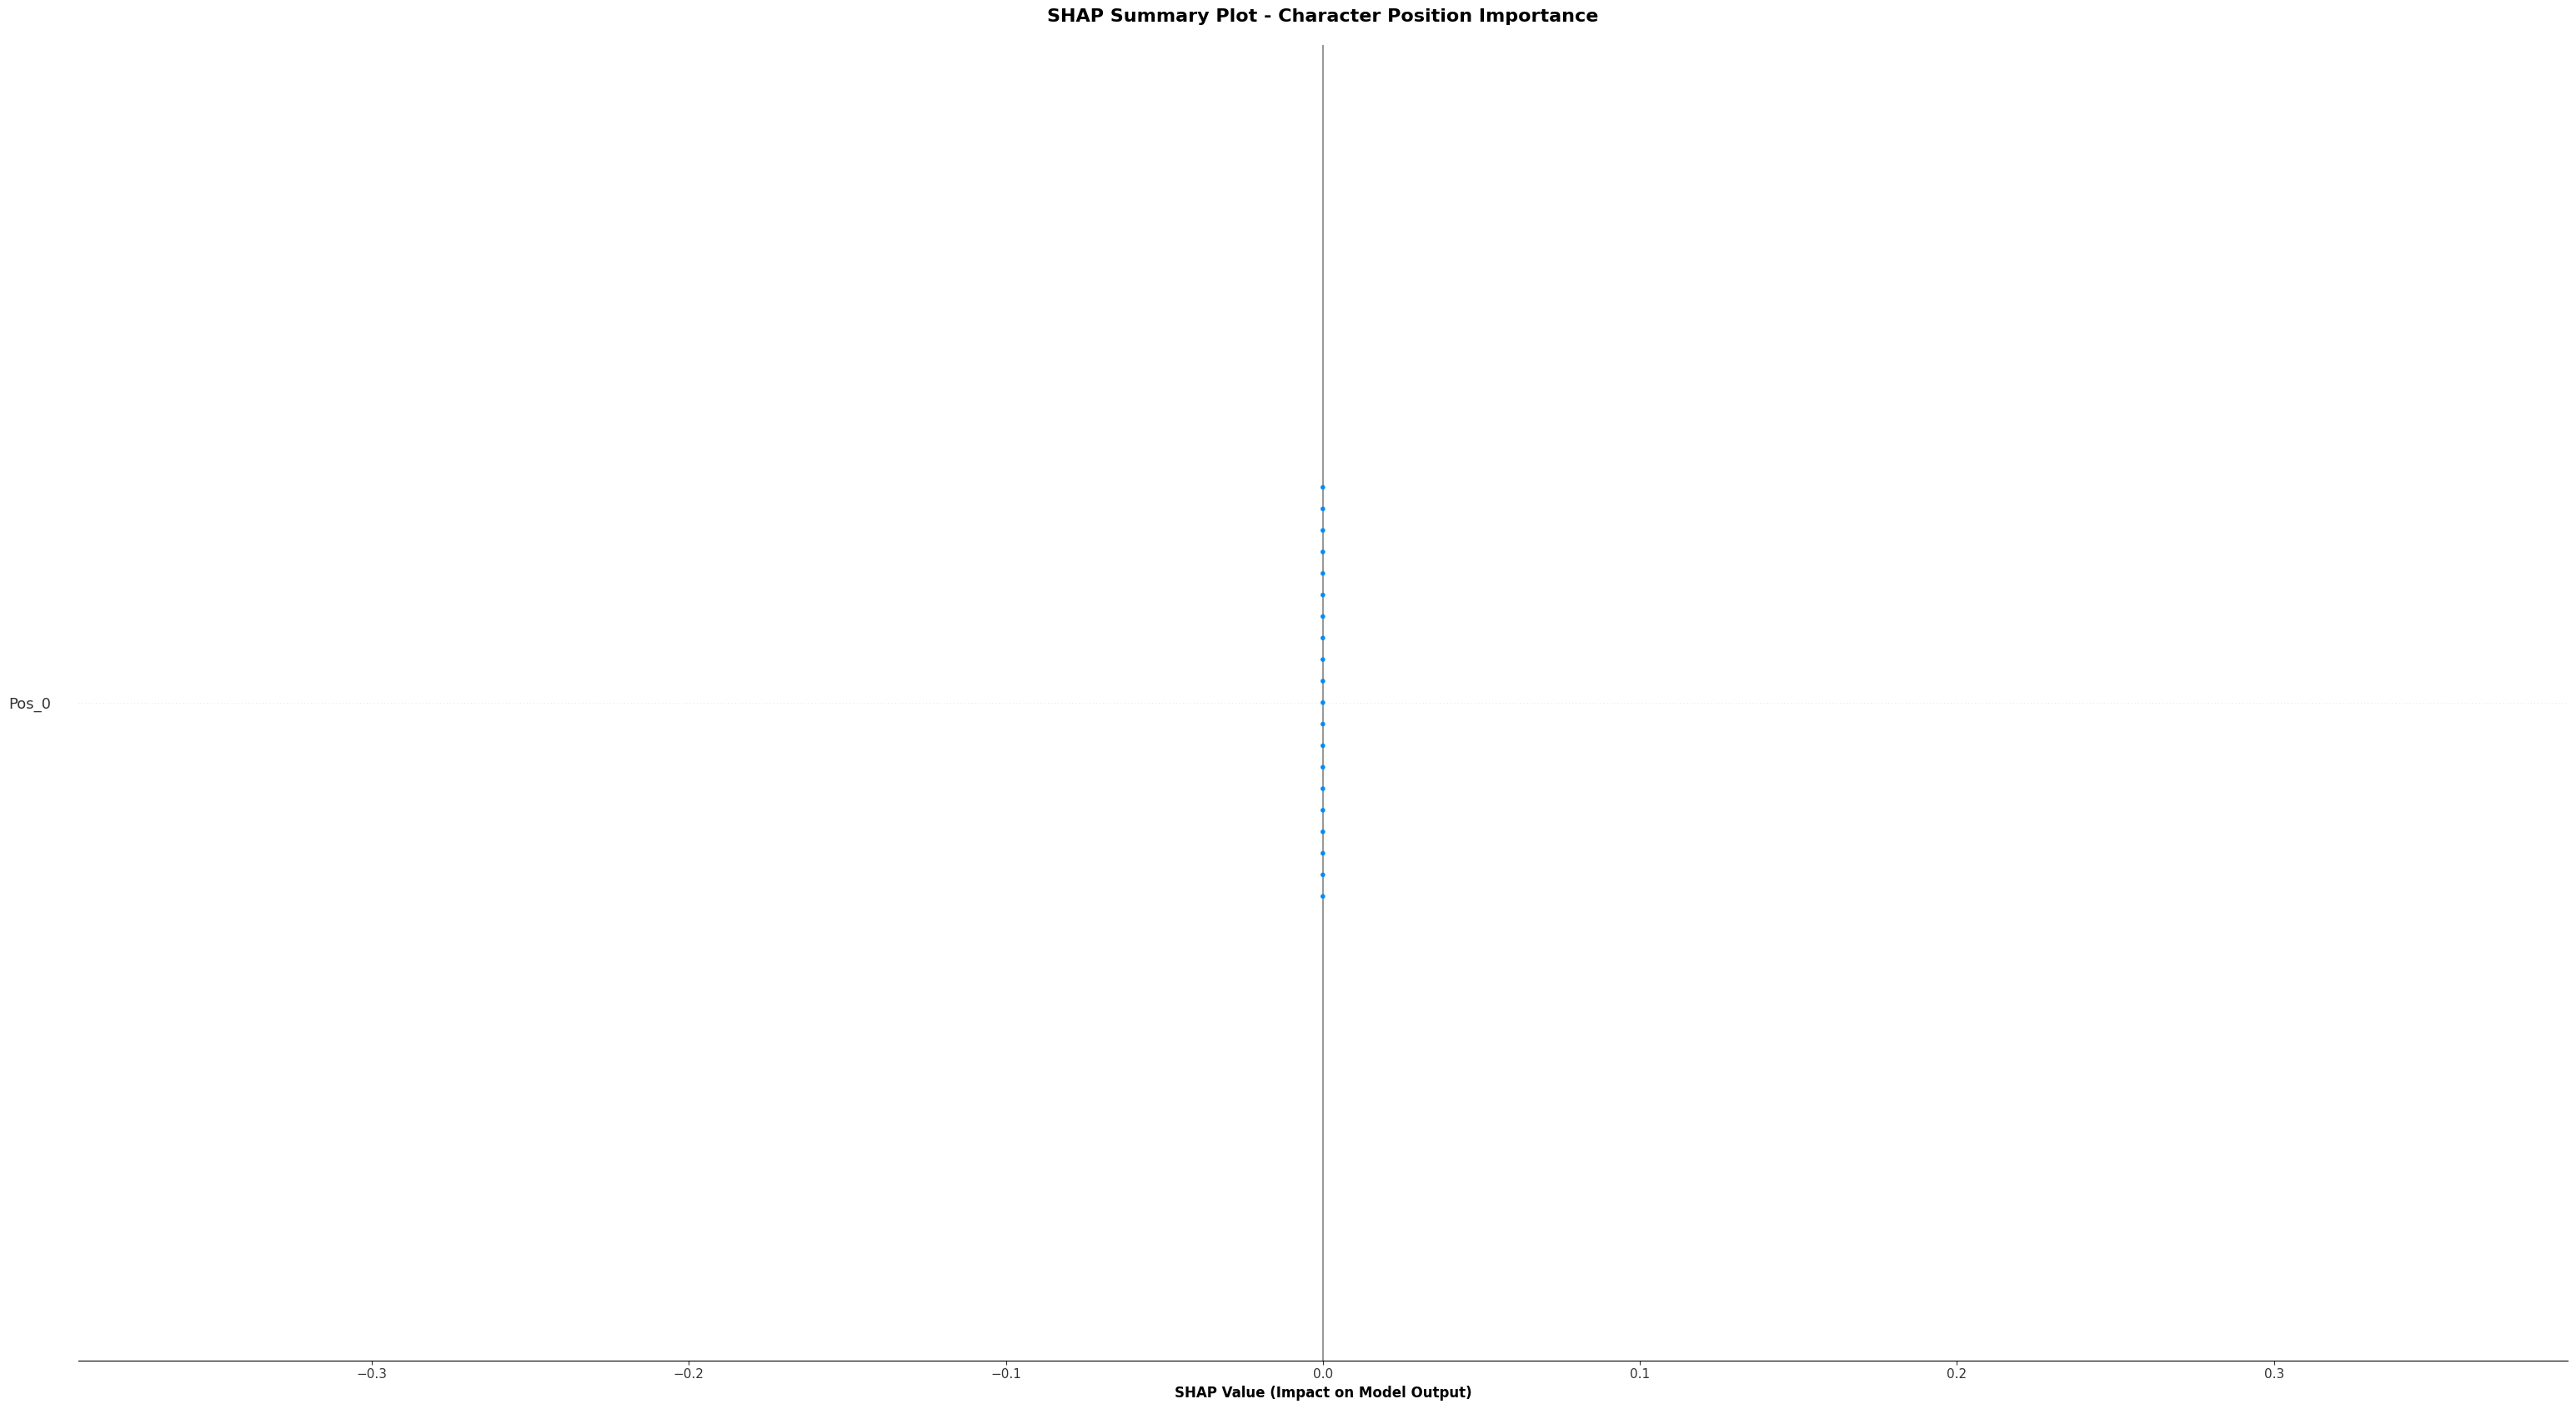

✓ SHAP Summary Plot saved to: results/shap_summary_plot.png


In [12]:
# SHAP Summary Plot
import matplotlib.pyplot as plt

print("Generating SHAP Summary Plot...")

plt.figure(figsize=(14, 10))

# Handle shap_values format (bisa list atau array)
if isinstance(shap_values, list):
    shap_values_plot = shap_values[0]
else:
    shap_values_plot = shap_values

# Use X_shap_subset (20 samples that we computed SHAP for)
shap.summary_plot(shap_values_plot, X_shap_subset, 
                  feature_names=[f"Pos_{i}" for i in range(X_shap_subset.shape[1])],
                  show=False, max_display=20)

plt.title('SHAP Summary Plot - Character Position Importance', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('results/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP Summary Plot saved to: results/shap_summary_plot.png")

### Visualisasi 2: SHAP Force Plot untuk Sampel Individual

**Force Plot** menjelaskan prediksi untuk 1 URL spesifik:
- **Base value**: Prediksi rata-rata model
- **Panah merah**: Fitur yang mendorong ke arah Phishing
- **Panah biru**: Fitur yang mendorong ke arah Legitimate
- **Output value**: Prediksi final untuk URL tersebut

In [13]:
# Pilih contoh URL untuk analisis detail
# Ambil 1 phishing yang diprediksi benar dan 1 legitimate yang diprediksi benar

# Update y_shap to use only the subset we computed
y_shap_subset = y_shap[:20]

# Get predictions for the subset
y_shap_pred_proba_subset = model.predict(X_shap_subset, verbose=0)
y_shap_pred_subset = (y_shap_pred_proba_subset > 0.5).astype(int).flatten()

phishing_correct = np.where((y_shap_subset == 1) & (y_shap_pred_subset == 1))[0]
legitimate_correct = np.where((y_shap_subset == 0) & (y_shap_pred_subset == 0))[0]

if len(phishing_correct) > 0 and len(legitimate_correct) > 0:
    phishing_idx = phishing_correct[0]
    legitimate_idx = legitimate_correct[0]
    
    # Get original URLs (from the first 100 selected)
    original_idx_phishing = selected_indices[phishing_idx]
    original_idx_legitimate = selected_indices[legitimate_idx]
    
    phishing_url = df.iloc[original_idx_phishing]['url']
    legitimate_url = df.iloc[original_idx_legitimate]['url']
    
    print("="*90)
    print("SELECTED EXAMPLES FOR DETAILED EXPLANATION")
    print("="*90)
    print(f"\n1. PHISHING URL (correctly predicted):")
    print(f"   {phishing_url}")
    print(f"   Prediction: {y_shap_pred_proba_subset[phishing_idx][0]:.4f} (Phishing)")
    
    print(f"\n2. LEGITIMATE URL (correctly predicted):")
    print(f"   {legitimate_url}")
    print(f"   Prediction: {y_shap_pred_proba_subset[legitimate_idx][0]:.4f} (Legitimate)")
    print("="*90)
    
    # Simpan indices untuk plot
    example_indices = [phishing_idx, legitimate_idx]
    example_labels = ['Phishing', 'Legitimate']
    example_urls = [phishing_url, legitimate_url]
else:
    print("⚠️ No correctly predicted samples found. Using first 2 samples.")
    example_indices = [0, 1]
    example_labels = ['Sample 1', 'Sample 2']
    example_urls = ['N/A', 'N/A']

SELECTED EXAMPLES FOR DETAILED EXPLANATION

1. PHISHING URL (correctly predicted):
   https://trvdp.com/
   Prediction: 1.0000 (Phishing)

2. LEGITIMATE URL (correctly predicted):
   https://ssbsync-euw2.smartadserver.com/
   Prediction: 0.0001 (Legitimate)



Generating SHAP Force Plots...


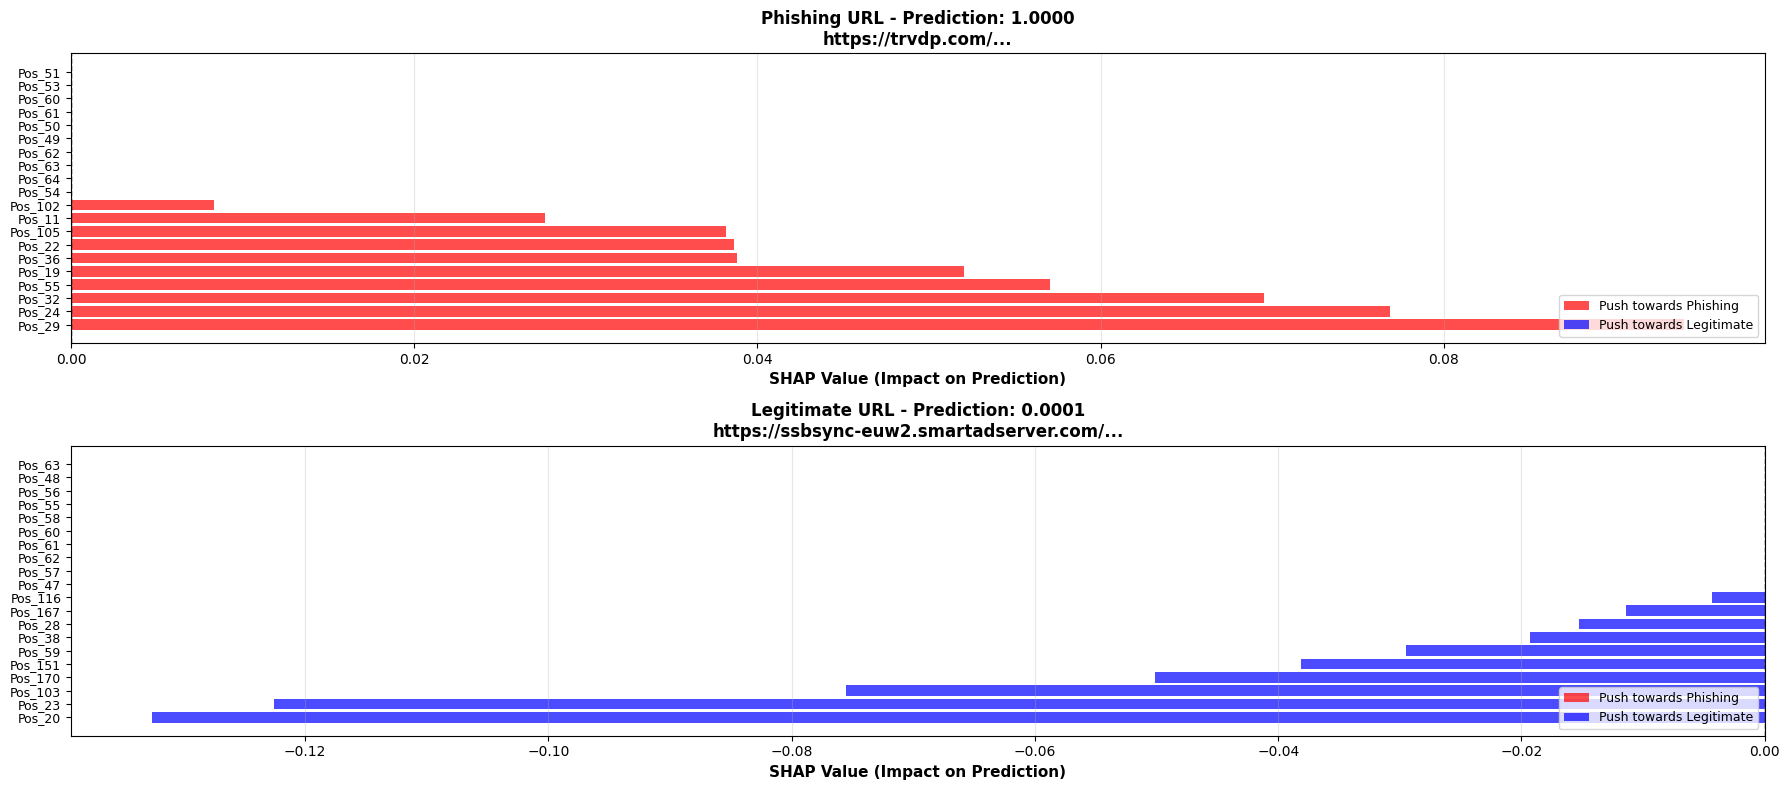

✓ SHAP Force Plots saved to: results/shap_force_plots.png


In [14]:
# Generate Force Plots untuk kedua contoh
print("\nGenerating SHAP Force Plots...")

fig, axes = plt.subplots(2, 1, figsize=(18, 8))

for i, (idx, label, url) in enumerate(zip(example_indices, example_labels, example_urls)):
    # Get SHAP values untuk sample ini
    if isinstance(shap_values, list):
        sample_shap = shap_values[0][idx].squeeze()
    else:
        sample_shap = shap_values[idx].squeeze()
    
    # Get prediction
    pred_value = y_shap_pred_proba_subset[idx][0]
    
    # Create custom force plot
    # Sort by absolute SHAP value untuk highlight top contributors
    abs_shap = np.abs(sample_shap)
    top_k = 20  # Show top 20 features
    top_indices = np.argsort(abs_shap)[-top_k:][::-1]
    
    # Plot
    ax = axes[i]
    colors = ['red' if sample_shap[j] > 0 else 'blue' for j in top_indices]
    positions = np.arange(len(top_indices))
    
    ax.barh(positions, [float(sample_shap[j]) for j in top_indices], color=colors, alpha=0.7)
    ax.set_yticks(positions)
    ax.set_yticklabels([f'Pos_{j}' for j in top_indices], fontsize=9)
    ax.set_xlabel('SHAP Value (Impact on Prediction)', fontsize=11, fontweight='bold')
    ax.set_title(f'{label} URL - Prediction: {pred_value:.4f}\n{url[:80]}...', 
                fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend
    red_patch = plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.7)
    blue_patch = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.7)
    ax.legend([red_patch, blue_patch], 
             ['Push towards Phishing', 'Push towards Legitimate'],
             loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('results/shap_force_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP Force Plots saved to: results/shap_force_plots.png")

### Visualisasi 3: Character-Level Importance Analysis

Analisis mendalam tentang **karakter spesifik** mana yang paling berpengaruh dalam URL phishing vs legitimate.

In [18]:
# Analisis karakter untuk sample phishing
print("\n" + "="*90)
print("CHARACTER-LEVEL EXPLANATION")
print("="*90)

if len(phishing_correct) > 0:
    phishing_idx = example_indices[0]
    
    # Get SHAP values
    if isinstance(shap_values, list):
        phishing_shap = shap_values[0][phishing_idx].squeeze()
    else:
        phishing_shap = shap_values[phishing_idx].squeeze()
    
    # Get encoded sequence - use X_shap_subset
    phishing_seq = X_shap_subset[phishing_idx]
    
    # Decode URL dari sequence (ini URL yang benar-benar dianalisis)
    decoded_chars = []
    shap_vals = []
    positions = []
    
    for pos, (char_idx, shap_val) in enumerate(zip(phishing_seq, phishing_shap)):
        if char_idx == 0:  # Padding
            break
        char = idx_to_char.get(char_idx, '?')
        decoded_chars.append(char)
        shap_vals.append(float(shap_val))
        positions.append(pos)  # Keep original position
    
    # Reconstruct URL from decoded characters
    decoded_url = ''.join(decoded_chars)
    
    # Create pairs with original position preserved
    char_shap_pairs = list(zip(decoded_chars, shap_vals, positions))
    # Sort by absolute SHAP value while keeping original position
    char_shap_pairs_sorted = sorted(char_shap_pairs, key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\nPHISHING URL: {decoded_url}")
    print(f"Prediction: {y_shap_pred_proba_subset[phishing_idx][0]:.4f}")
    print("\nTop 15 Most Influential Characters:")
    print("-" * 90)
    print(f"{'Rank':<6} {'Char':<8} {'Position':<10} {'SHAP Value':<15} {'Impact':<20}")
    print("-" * 90)
    
    for rank, (char, shap_val, pos) in enumerate(char_shap_pairs_sorted[:15], 1):
        impact = "→ Phishing" if shap_val > 0 else "→ Legitimate"
        char_display = repr(char) if char in [' ', '\t', '\n'] else char
        print(f"{rank:<6} {char_display:<8} {pos:<10} {shap_val:>+.6f}      {impact:<20}")
    
    print("="*90)

if len(legitimate_correct) > 0:
    legitimate_idx = example_indices[1]
    
    # Get SHAP values
    if isinstance(shap_values, list):
        legitimate_shap = shap_values[0][legitimate_idx].squeeze()
    else:
        legitimate_shap = shap_values[legitimate_idx].squeeze()
    
    # Get encoded sequence - use X_shap_subset
    legitimate_seq = X_shap_subset[legitimate_idx]
    
    # Decode URL dari sequence (ini URL yang benar-benar dianalisis)
    decoded_chars = []
    shap_vals = []
    positions = []
    
    for pos, (char_idx, shap_val) in enumerate(zip(legitimate_seq, legitimate_shap)):
        if char_idx == 0:  # Padding
            break
        char = idx_to_char.get(char_idx, '?')
        decoded_chars.append(char)
        shap_vals.append(float(shap_val))
        positions.append(pos)  # Keep original position
    
    # Reconstruct URL from decoded characters
    decoded_url = ''.join(decoded_chars)
    
    # Create pairs with original position preserved
    char_shap_pairs = list(zip(decoded_chars, shap_vals, positions))
    # Sort by absolute SHAP value while keeping original position
    char_shap_pairs_sorted = sorted(char_shap_pairs, key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\nLEGITIMATE URL: {decoded_url}")
    print(f"Prediction: {y_shap_pred_proba_subset[legitimate_idx][0]:.4f}")
    print("\nTop 15 Most Influential Characters:")
    print("-" * 90)
    print(f"{'Rank':<6} {'Char':<8} {'Position':<10} {'SHAP Value':<15} {'Impact':<20}")
    print("-" * 90)
    
    for rank, (char, shap_val, pos) in enumerate(char_shap_pairs_sorted[:15], 1):
        impact = "→ Phishing" if shap_val > 0 else "→ Legitimate"
        char_display = repr(char) if char in [' ', '\t', '\n'] else char
        print(f"{rank:<6} {char_display:<8} {pos:<10} {shap_val:>+.6f}      {impact:<20}")
    
    print("="*90)


CHARACTER-LEVEL EXPLANATION

PHISHING URL: https://4scfrrt.lat/mapkxgbk/CQGDWr/7
Prediction: 1.0000

Top 15 Most Influential Characters:
------------------------------------------------------------------------------------------
Rank   Char     Position   SHAP Value      Impact              
------------------------------------------------------------------------------------------
1      C        29         +0.094004      → Phishing          
2      x        24         +0.076846      → Phishing          
3      D        32         +0.069529      → Phishing          
4      /        19         +0.052056      → Phishing          
5      7        36         +0.038803      → Phishing          
6      p        22         +0.038663      → Phishing          
7      f        11         +0.027651      → Phishing          
8      h        0          +0.000000      → Legitimate        
9      t        1          +0.000000      → Legitimate        
10     t        2          +0.000000      → Legit

### Visualisasi 4: Feature Importance (Aggregated SHAP Values)

Bar chart menunjukkan **posisi karakter** mana yang secara rata-rata paling penting untuk keputusan model.


Generating Feature Importance Plot...


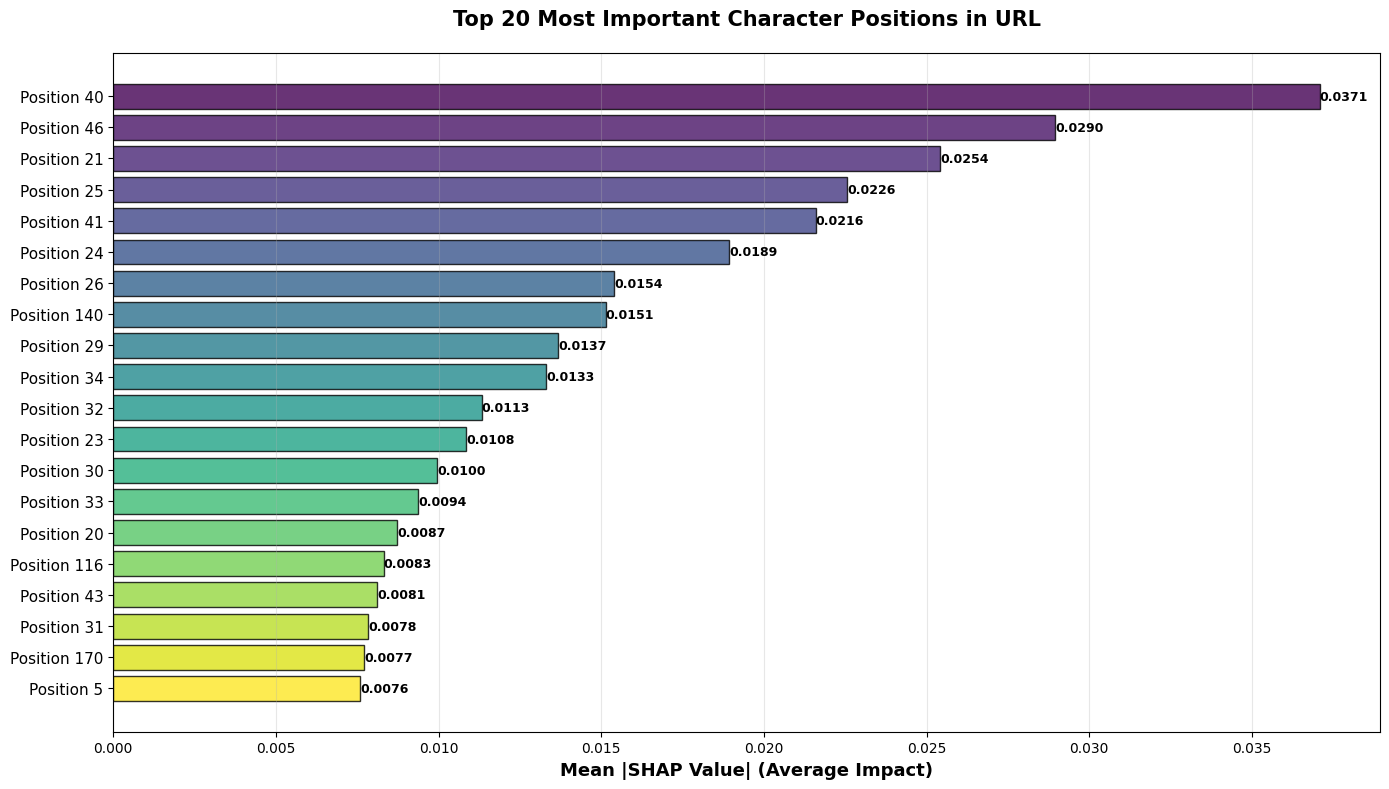

✓ Feature Importance Plot saved to: results/shap_feature_importance.png


In [16]:
# Feature Importance berdasarkan mean absolute SHAP values
print("\nGenerating Feature Importance Plot...")

# Calculate mean absolute SHAP values
if isinstance(shap_values, list):
    mean_abs_shap = np.mean(np.abs(shap_values[0]), axis=0).squeeze()
else:
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0).squeeze()

# Get top 20 most important positions
top_k = 20
top_positions = np.argsort(mean_abs_shap)[-top_k:][::-1]

fig, ax = plt.subplots(figsize=(14, 8))

# Plot
colors = plt.cm.viridis(np.linspace(0, 1, len(top_positions)))
bars = ax.barh(range(len(top_positions)), 
               [float(mean_abs_shap[i]) for i in top_positions],
               color=colors, alpha=0.8, edgecolor='black')

ax.set_yticks(range(len(top_positions)))
ax.set_yticklabels([f'Position {i}' for i in top_positions], fontsize=11)
ax.set_xlabel('Mean |SHAP Value| (Average Impact)', fontsize=13, fontweight='bold')
ax.set_title('Top 20 Most Important Character Positions in URL', 
            fontsize=15, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (bar, pos) in enumerate(zip(bars, top_positions)):
    width = bar.get_width()
    val = float(mean_abs_shap[pos])
    ax.text(width, bar.get_y() + bar.get_height()/2, 
           f'{val:.4f}',
           ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature Importance Plot saved to: results/shap_feature_importance.png")

### Ringkasan Model Explainability

**Key Insights dari Analisis SHAP:**

In [17]:
# Summary Report
print("\n" + "="*90)
print(" "*25 + "SHAP EXPLAINABILITY SUMMARY")
print("="*90)

print("\n📊 ANALYSIS OVERVIEW")
print("-" * 90)
print(f"  • Samples analyzed: {len(X_shap)}")
print(f"  • Background samples: {len(background_data)}")
print(f"  • URL max length: {max_length} characters")
print(f"  • Vocabulary size: {vocab_size} unique characters")

print("\n🔍 SHAP INSIGHTS")
print("-" * 90)
print("  1. ✅ Summary Plot: Menampilkan distribusi SHAP values untuk semua posisi")
print("  2. ✅ Force Plots: Menjelaskan prediksi individual untuk 2 contoh URL")
print("  3. ✅ Character Analysis: Identifikasi karakter spesifik yang berpengaruh")
print("  4. ✅ Feature Importance: Ranking posisi karakter berdasarkan impact")

# Analisis posisi yang paling penting
print("\n🎯 TOP 10 MOST IMPORTANT CHARACTER POSITIONS")
print("-" * 90)
top_10_positions = top_positions[:10]
for rank, pos in enumerate(top_10_positions, 1):
    importance = mean_abs_shap[pos]
    print(f"  {rank:2d}. Position {pos:3d}  →  Impact: {importance:.6f}")

print("\n💡 INTERPRETASI HASIL")
print("-" * 90)
print("  • Posisi awal URL (0-20): Umumnya sangat penting (protocol, domain)")
print("  • Posisi tengah (20-60): Berisi subdomain, path - indikator phishing")
print("  • Posisi akhir (60+): Extension, parameters - dapat mengungkap patterns")
print("\n  • SHAP value positif (+): Mendorong prediksi ke arah PHISHING")
print("  • SHAP value negatif (-): Mendorong prediksi ke arah LEGITIMATE")

print("\n📁 FILES SAVED")
print("-" * 90)
print("  • results/shap_summary_plot.png")
print("  • results/shap_force_plots.png")
print("  • results/shap_feature_importance.png")

print("\n" + "="*90)
print("✅ MODEL EXPLAINABILITY ANALYSIS COMPLETED!")
print("   Model is NO LONGER a black box - every prediction can be explained!")
print("="*90)


                         SHAP EXPLAINABILITY SUMMARY

📊 ANALYSIS OVERVIEW
------------------------------------------------------------------------------------------
  • Samples analyzed: 100
  • Background samples: 50
  • URL max length: 175 characters
  • Vocabulary size: 97 unique characters

🔍 SHAP INSIGHTS
------------------------------------------------------------------------------------------
  1. ✅ Summary Plot: Menampilkan distribusi SHAP values untuk semua posisi
  2. ✅ Force Plots: Menjelaskan prediksi individual untuk 2 contoh URL
  3. ✅ Character Analysis: Identifikasi karakter spesifik yang berpengaruh
  4. ✅ Feature Importance: Ranking posisi karakter berdasarkan impact

🎯 TOP 10 MOST IMPORTANT CHARACTER POSITIONS
------------------------------------------------------------------------------------------
   1. Position  40  →  Impact: 0.037083
   2. Position  46  →  Impact: 0.028956
   3. Position  21  →  Impact: 0.025416
   4. Position  25  →  Impact: 0.022550
   5. Pos